# Stroke Project

# Goals
* Discover the drivers that increase the risk factor of stroke
* Use drivers to develop a machine learning model to predict weather or not a patient has had a stroke.
* Use findings to see what preventitave measures if any can be taken to decrease the risk of stroke

### Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import wrangle as w
import explore as e
import model as m

from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Decision Tree and Model Evaluation Imports
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# Acquire
* Data acquired from kaggle on 12-13-2022
    https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv
* Data contains 5110 rows and 12 columns
* Each row represents a patient and information about the patient
* Each column representa a features related to the patient

In [3]:
# acquire data from csv file
df= w.get_stroke_data()

# Prepare
prepare actions:
  * removed columns with unnecessary information
  * renamed columns and values
  * 211 null values where found and will be imputed after split
  * Outliers have not been removed
  * Encoded categorical variables
  * Split data into train, validate and test:
        (Approximately: train 56%, validate 24%, test 20%)

  * impute 211 null values under BMI column with median due to the right skewness of feature 
  
  * Continuous variables will be scaled before modeling.

In [4]:
# prepare data
df = w.data_prep(df)

In [5]:
# split data and impute bmi by mean
train, validate, test = w.split_and_impute_data(df, 'stroke')

# Data Dictionary

| Feature    | Description    | 
| :------------- | -------------: | 
|      id     |   unique identifier      | 
|   gender       |    Gender of patient Male or Female or Other     | 
| age|     age of the patient     | 
|      hypertension    |     If a patient has hypertension  (1 = yes, 0 = no)  | 
|      hear_disease     |     If a patient has any heart diseases  (1 = yes, 0 = no)  | 
|       ever_married   |   If a patient has ever been married (1 = yes, 0 = no)      | 
|    work_type       |    The work type of patient. *Children are under children category     | 
|  residence_type        |     If a patient residence is  rural of urban   | 
|   avg_glucose_level        |    average glucose level in blood     | 
|     bmi     |   body mass index of patient      | 
|   smoking_status       |    smoking status of patient * Unknown represent the information was unavailable     | 
|          |         | 

# Explore

# 1. What is the percent of patients who have a stroke?


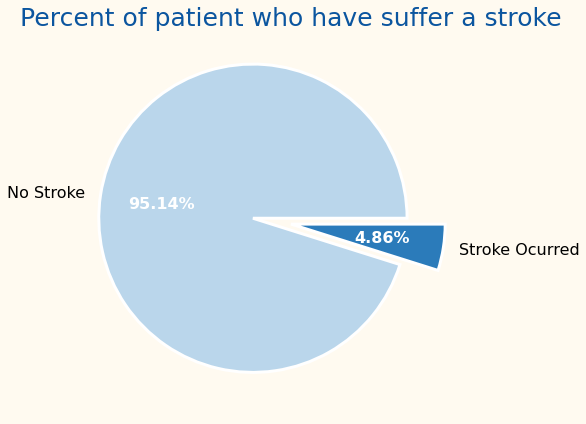

In [6]:
# obtain visualization for percent of patients who have suffer a stroke
e.viz_stroke_percentage(train)

***About 5 % of our patients have suffer a stroke***

# 2. Does the presense of hypertension increase the risk of stroke?


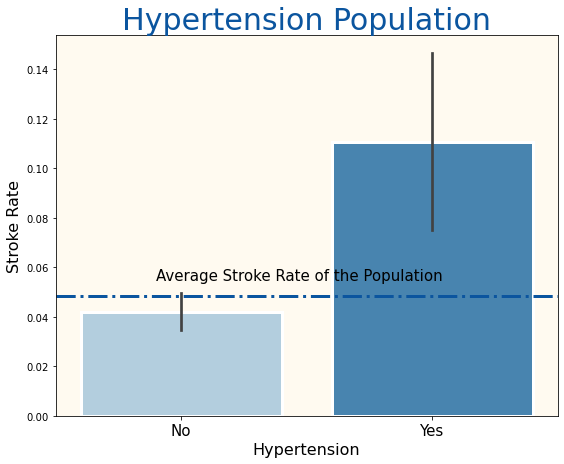

In [7]:
# obtain visualization for hypertension vs stroke
e.viz_hypertension_vs_stroke(train)

***It appears that patients with hypertension tend to have a higher stroke rate than patients without hypertension***

### I will now conduct a chi-square test to determine if there is an association between hypertension  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Hypertension is **independent**   of stroke.

$H_a$: Hypertension is **dependent** of stroke.

In [8]:
# obtain chi square test
e.chi_square_test(train,'stroke', 'hypertension')

 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07


Since the p-value is less than alpha we reject the null hypothesis. There is evidence to support that hypertention has an association with stroke. I believe that hypertention is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 3. Are patients with a heart condition more at risk of stroke than patients with hypertension?

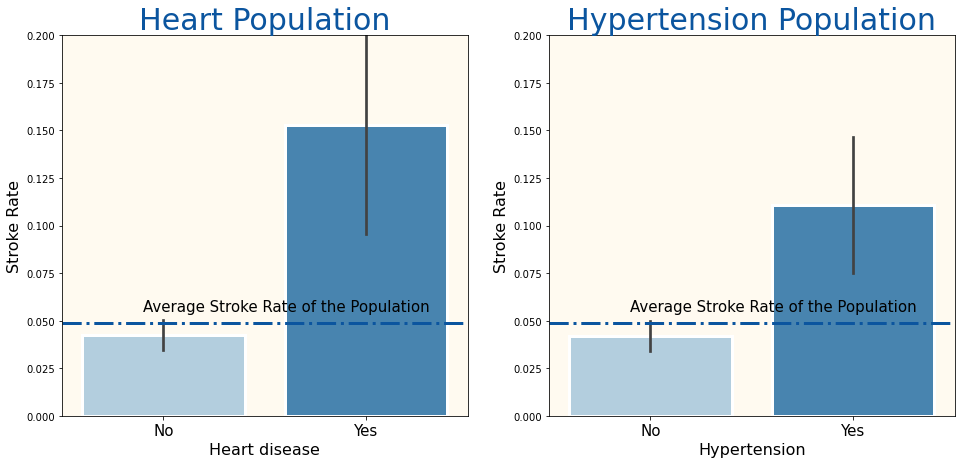

In [9]:
# obtain visualization for heart disease populatin vs stroke and hypertension population vs stroke
e. viz_heart_hyper_stroke(train)

***It appears that patients with a heart condition tend to have a higher stroke rate than patients with hypertension***

### I will now conduct a chi-square test to determine if there is an association between heart condition  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$: Patients with a heart condition is **independent**   of stroke.

$H_a$: Patients with a heart condition **dependent** of stroke.

In [10]:
# obtain chi square test
e.chi_square_test(train,'stroke', 'heart_disease')

 Chi-Square:36.73001998146243
 p-value:1.356740136221253e-09


Since the p-value is less than alpha we reject the null hypothesis. There is evidence to support that patients with heart disease has an association with stroke. I believe that heart disease is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 4. Controling for gender of a patient, does heart disease increases risk of stroke?

In [11]:
# create subgroups for male and female
male_subset = train[train.gender_Male==1]
female_subset = train[train.gender_Male==0]

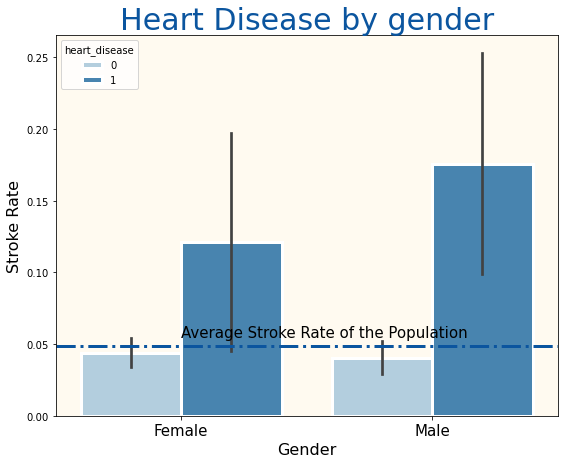

In [12]:
# obtain visualization controling for gender heart disease vs stroke
e.viz_gender_heart_stroke(train)

***It appears that males with hypertension have an above average stroke rate.
Also males with hypertensio have a higher stroke rate than females***

### I will now conduct a chi-square test  is the male population with heart disease associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Males with hypertension is **independent**   of stroke.

$H_a$: Males with hypertension is **dependent** of stroke.

In [13]:
e.chi_square_test(male_subset,'stroke', 'heart_disease')


 Chi-Square:29.08260992156263
 p-value:6.935676062013279e-08


Since the p-value is less than alpha we reject the null Hypothesis. There is evidence to support that males a heart disease has an association with stroke.  Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

### I will now conduct a chi-square test  is the female population with heart disease associated with stroke.
* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Females with hypertension is **independent**   of stroke.

$H_a$: Females with hypertension is **dependent** of stroke.

In [14]:
e.chi_square_test(female_subset,'stroke', 'heart_disease')

 Chi-Square:6.8306066361801525
 p-value:0.008960882580754448


Since the p-value is less than alpha we reject the null Hypothesis. There is evidence to support that females with a heart diseas has an association with stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 5. Is age a driver of stroke?

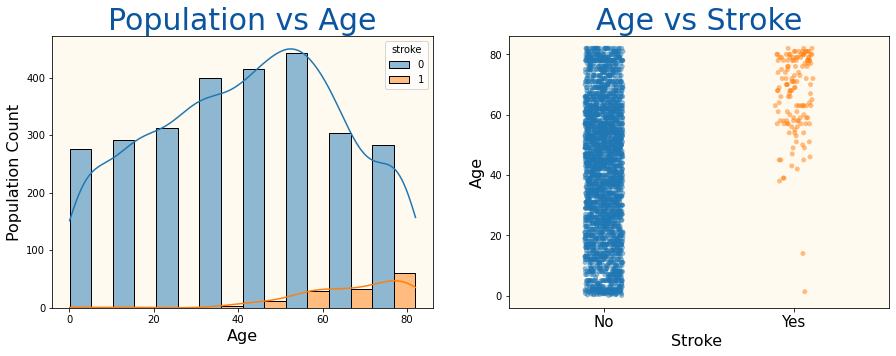

In [15]:
# obtain graph age vs stroke
e.viz_age_vs_stroke(train)

***It seems that with as our patients age increases so does the instances of occurance of a stroke.***

### I will conduct a t-test to determine if the population who has suffer a stroke has a higher mean age thatn the population who has not had a stoke occurance.
* The confidence interval is 95%
* Alpha is set to 0.05
* This will be a Independent t-test

$H_0$ : The mean age of patients who have suffer a stroke <= to the mean age of patients who have not suffer a stroke

$H_a$: The mean age of patients who have suffer a stroke > to the mean age of patients who have not suffer a stroke


In [16]:
# obtain ttest for age vs stroke
e.ttest(train,'stroke','age')

t-stat 20.108050826301564
p-value 5.1422688960466496e-48


Since the p-value/2 is less than alpha we reject the null Hypothesis. There is evidence to support that patients who suffer a stroke  on average are older than patients who have not suffer a stroke. Based on this statistical finding I believe that age is a driver of stroke. Adding an scaled version of this feature to the model will likely increase the model ability to predict home value.

# 6. Do patients who have ever been married suffer more strokes than patients that have not been married

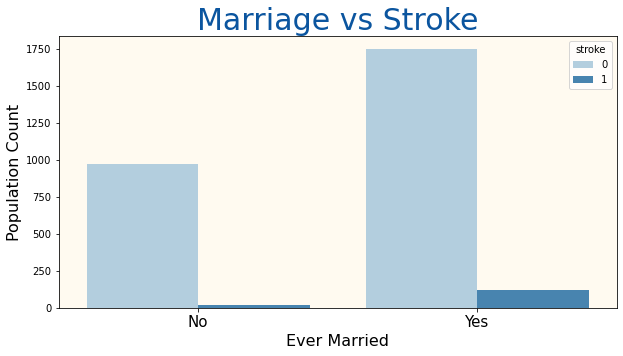

In [17]:
# visualization for patients who have been married vs stroke
e.viz_marriage_vs_stroke(train)

***There seems to be a slight increase in stroke for those patients who have been married.***

### I will now conduct a chi-square test  if patients who have been married is associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Patients who have been married are **independent**   of stroke.

$H_a$: Patients who have been married are not **dependent** of stroke.

In [18]:
e.chi_square_test(train, 'stroke','ever_married_Yes')

 Chi-Square:33.01784652416314
 p-value:9.131679279313294e-09


The p-value is less than alpha and we reject the null hypothesis. There is evidence to support that patients who have been married has an association with stroke. I believe that marriage is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# Exploration Summary

* 4.86% of our patient populatin has suffer a stroke
* Patients with hypertension have an increase in stroke rate
* Patients with heart disease have an increase in stroke rate
* Patients wih heart disease have a larger increase in stroke rate than patients with hypertension
* The male gender of our patients that have heart disease have a higher stroke rate than the female gender
* The patients age is a driver of stroke
* Patients who have been married have a slight increase in stroke rate.

# Features that will be included in my model:

The following features where found significant trough exploration and statistical testing and will be kept for modeling:
* hypertension 
* heart_disease
* gender_Male (encoded)
* age (scaled)
* ever_married_Yes (encoded)

Target variable: Stroke

In [19]:
# save features kept for modeling
modeling_features = ['hypertension','heart_disease','gender_Male','age','ever_married_Yes', 'stroke']

# Features that will be not included in my model:

The following features will not be used for this iteration of modeling:
* work_type
* residence_type
* avg_glucose_level
* bmi
* smoking_status


# Modeling:
* Accuracy is the metric use in the models.
    * Accuracy helps gauge the percentage of correct predictions
* Patients who have suffer a stroke makeup 4.86% of the data
* 95.14% will be the baseline
* I will evaluate my top model on train and validate data
* The model that performs the best will then be evaluated on test data

In [20]:
X_train,y_train,X_validate,y_validate, X_test, y_test= m.model_prep(train,validate,test,modeling_features)

In [21]:
y_validate.shape,X_validate.shape,X_train.shape,y_train.shape,X_test.shape, y_test.shape

((1227,), (1227, 5), (2861, 5), (2861,), (1022, 5), (1022,))

X_train['baseline_prediction'] = int(baseline)
X_train


#Loop for models
for i in range(1, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i,min_samples_split = 5, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [24]:
y_validate.shape,X_validate.shape,X_train.shape,y_train.shape

((1227,), (1227, 5), (2861, 5), (2861,))

In [44]:

metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    

    
    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    # calculate recall train
    y_pred = tree.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  
      
    # calculate recall validate
    y_pred = tree.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,1,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
1,2,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
2,3,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
3,4,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
4,5,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
5,6,0.952115,0.951915,0.035971,0.033333,0.000199,0.002638
6,7,0.953513,0.947840,0.071942,0.016667,0.005672,0.055276
7,8,0.955610,0.941320,0.129496,0.033333,0.014290,0.096163
8,9,0.955959,0.943765,0.136691,0.033333,0.012194,0.103357
9,10,0.956309,0.941320,0.129496,0.033333,0.014989,0.096163


In [26]:
df.sort_values(by=['recall_difference', 'train_recall'])

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,1,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
1,2,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
2,3,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
3,4,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
4,5,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
5,6,0.952115,0.951915,0.035971,0.033333,0.000199,0.002638
6,7,0.953513,0.947840,0.071942,0.016667,0.005672,0.055276
7,8,0.955610,0.941320,0.129496,0.033333,0.014290,0.096163
9,10,0.956309,0.941320,0.129496,0.033333,0.014989,0.096163
8,9,0.955959,0.943765,0.136691,0.033333,0.012194,0.103357


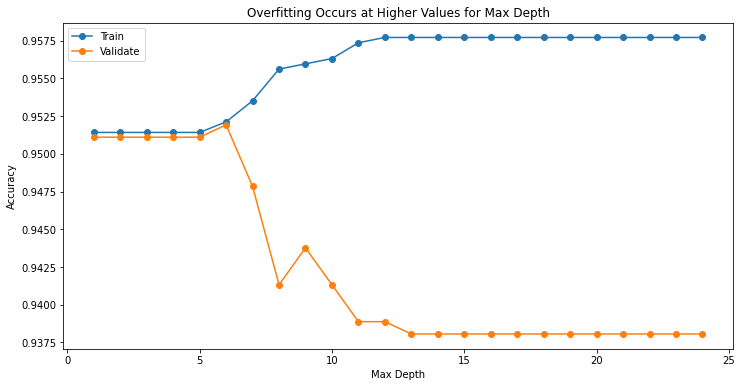

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o', label = 'Train')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o', label = 'Validate')


#plt.plot(df_2.max_depth, df_2.validate_accuracy, marker = 'x', label = 'Validate')

plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:

# Random forest changing leaf

metrics=[]
for i in range(1, 21):
  
    # Make the model
    random_forest = RandomForestClassifier(max_depth=8, min_samples_leaf = i , random_state=123)

    # Fit the model (on train and only train)
    random_forest = random_forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_pred = random_forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_pred, output_dict=True)
    print(f"Tree with min sample leaf {i}")
    print(pd.DataFrame(report))
    print()
    
    
    # create data frame
        # calculate recall train
    y_pred = random_forest.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)
    
    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = random_forest.score(X_train, y_train)
    
    
    
    out_of_sample_accuracy = random_forest.score(X_validate, y_validate)

    
      
    # calculate recall validate
    y_pred = random_forest.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }
    
    metrics.append(output)
    
df6 = pd.DataFrame(metrics)
df6["accuracy_difference"] = df6.train_accuracy - df6.validate_accuracy
df6["recall_difference"] = df6.train_recall - df6.validate_recall
df6
 

Tree with min sample leaf 1
                     0           1  accuracy    macro avg  weighted avg
precision     0.957379    0.818182  0.956309     0.887781      0.950617
recall        0.998530    0.129496  0.956309     0.564013      0.956309
f1-score      0.977522    0.223602  0.956309     0.600562      0.940893
support    2722.000000  139.000000  0.956309  2861.000000   2861.000000

Tree with min sample leaf 2
                     0           1  accuracy    macro avg  weighted avg
precision     0.954386    0.818182  0.953862     0.886284      0.947769
recall        0.999265    0.064748  0.953862     0.532007      0.953862
f1-score      0.976310    0.120000  0.953862     0.548155      0.934707
support    2722.000000  139.000000  0.953862  2861.000000   2861.000000

Tree with min sample leaf 3
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,1,0.956309,0.945395,0.129496,0.016667,0.010914,0.112830
1,2,0.953862,0.947840,0.064748,0.000000,0.006022,0.064748
2,3,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
3,4,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
4,5,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
5,6,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
6,7,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
7,8,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
8,9,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
9,10,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000


In [82]:
df6.sort_values(by=['validate_accuracy','validate_recall'],ascending= False)

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
2,3,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
3,4,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
4,5,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
5,6,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
6,7,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
7,8,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
8,9,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
9,10,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
10,11,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000
11,12,0.951416,0.951100,0.000000,0.000000,0.000315,0.000000


In [87]:
# Random forest changing max-depth and leaf
metrics =[]
for h in range(10,0,-1):
    print(f'max depth {h}')
    for i in range(1, 21):
  
        # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)

        # Fit the model (on train and only train)
        random_forest = random_forest.fit(X_train, y_train)

        # Use the model
        # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(X_train)
        # calculate recall validate

        in_sample_recall= recall_score(y_train, y_pred)     

        # Produce the classification report on the actual y values and this model's predicted y values
        report = classification_report(y_train, y_pred, output_dict=True)
        print(f"Tree with min sample leaf {i}")
        print(f'max depth {h}')
        print(pd.DataFrame(report))
        print()
        
        
        # calculate recall validate
        y_pred = random_forest.predict(X_validate)
        out_of_sample_recall= recall_score(y_validate, y_pred)
        
        # Produce the classification report on the actual y values and this model's predicted y values
        report = classification_report(y_validate, y_pred, output_dict=True)
        print(f"Tree with min sample leaf {i}")
        print(f'max depth {h}')
        print(pd.DataFrame(report))
        print()
        
        output = {
            "max_depth": h,
            'leaf_min':i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            'train_recall': in_sample_recall,
            'validate_recall': out_of_sample_recall
        }

        metrics.append(output)

df2 = pd.DataFrame(metrics)
df2["accuracy_difference"] = df2.train_accuracy - df2.validate_accuracy
df2["recall_difference"] = df2.train_recall - df2.validate_recall


max depth 10
Tree with min sample leaf 1
max depth 10
                     0           1  accuracy    macro avg  weighted avg
precision     0.959378    0.800000  0.957707     0.879689      0.951635
recall        0.997796    0.172662  0.957707     0.585229      0.957707
f1-score      0.978210    0.284024  0.957707     0.631117      0.944483
support    2722.000000  139.000000  0.957707  2861.000000   2861.000000

Tree with min sample leaf 1
max depth 10
                     0          1  accuracy    macro avg  weighted avg
precision     0.951320   0.066667  0.940505     0.508993      0.908061
recall        0.988003   0.016667  0.940505     0.502335      0.940505
f1-score      0.969315   0.026667  0.940505     0.497991      0.923220
support    1167.000000  60.000000  0.940505  1227.000000   1227.000000

Tree with min sample leaf 2
max depth 10
                     0           1  accuracy    macro avg  weighted avg
precision     0.955376    0.800000  0.954561     0.877688      0.947827
rec

Tree with min sample leaf 12
max depth 10
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 12
max depth 10
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 13
max depth 10
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-sco

Tree with min sample leaf 4
max depth 9
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 4
max depth 9
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 5
max depth 9
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score    

Tree with min sample leaf 16
max depth 9
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 16
max depth 9
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 17
max depth 9
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 8
max depth 8
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 8
max depth 8
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 9
max depth 8
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score    

Tree with min sample leaf 20
max depth 8
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 20
max depth 8
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

max depth 7
Tree with min sample leaf 1
max depth 7
                     0           1  accuracy    macro avg  weighted avg
precision     0.955040    0.785714  0.954212     0.870377      0.946814
recall        0.998898    0.079137  0.954212     0.5390

Tree with min sample leaf 12
max depth 7
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 12
max depth 7
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 13
max depth 7
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 3
max depth 6
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 3
max depth 6
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 4
max depth 6
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score    

Tree with min sample leaf 15
max depth 6
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 15
max depth 6
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 16
max depth 6
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 6
max depth 5
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 6
max depth 5
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 7
max depth 5
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score    

Tree with min sample leaf 19
max depth 5
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 19
max depth 5
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 20
max depth 5
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 10
max depth 4
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 10
max depth 4
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 11
max depth 4
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 1
max depth 3
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 1
max depth 3
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 2
max depth 3
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score    

Tree with min sample leaf 13
max depth 3
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 13
max depth 3
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 14
max depth 3
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 5
max depth 2
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 5
max depth 2
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 6
max depth 2
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score    

Tree with min sample leaf 17
max depth 2
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 17
max depth 2
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 18
max depth 2
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score 

Tree with min sample leaf 9
max depth 1
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score      0.975103    0.0  0.951416     0.487551      0.927728
support    2722.000000  139.0  0.951416  2861.000000   2861.000000

Tree with min sample leaf 9
max depth 1
                     0     1  accuracy    macro avg  weighted avg
precision     0.951100   0.0    0.9511     0.475550      0.904592
recall        1.000000   0.0    0.9511     0.500000      0.951100
f1-score      0.974937   0.0    0.9511     0.487469      0.927263
support    1167.000000  60.0    0.9511  1227.000000   1227.000000

Tree with min sample leaf 10
max depth 1
                     0      1  accuracy    macro avg  weighted avg
precision     0.951416    0.0  0.951416     0.475708      0.905192
recall        1.000000    0.0  0.951416     0.500000      0.951416
f1-score   

In [84]:
pd.set_option('display.max_rows', 500)
df2.sort_values(by=['validate_accuracy','validate_recall'],ascending= False)

,max_depth,leaf_min,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,10,1,0.951416,0.9511,0.172662,0.016667,0.000315,0.155995
20,9,1,0.951416,0.9511,0.143885,0.016667,0.000315,0.127218
40,8,1,0.951416,0.9511,0.129496,0.016667,0.000315,0.112830
1,10,2,0.951416,0.9511,0.086331,0.000000,0.000315,0.086331
2,10,3,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000
3,10,4,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000
4,10,5,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000
5,10,6,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000
6,10,7,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000
7,10,8,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000


In [30]:

metrics=[]
for h in range(10,0,-1):
   
    print(f'max depth {h}')
    
    for i in range(1, 21):
  
    # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)
    
    # Fit the model (on train and only train)
        random_forest.fit(X_train, y_train)
        
         # Use the model
    # We'll evaluate the model's performance on train, first
        in_sample_accuracy = random_forest.score(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(X_train)
        
        output = {
        "max_depth": h,
        "min_samples_leaf": i,
        "train_accuracy": in_sample_accuracy,
        #"validate_accuracy": y_pred
    }

        metrics.append(output)
        
        df5 = pd.DataFrame(metrics)
df5
  

max depth 10
max depth 9
max depth 8
max depth 7
max depth 6
max depth 5
max depth 4
max depth 3
max depth 2
max depth 1


,max_depth,min_samples_leaf,train_accuracy
0,10,1,0.957707
1,10,2,0.954561
2,10,3,0.951416
3,10,4,0.951416
4,10,5,0.951416
...,...,...,...
195,1,16,0.951416
196,1,17,0.951416
197,1,18,0.951416
198,1,19,0.951416


In [31]:
df.sort_values(by='train_accuracy')

,max_depth,min_samples_leaf,train_accuracy
99,6,20,0.951416
127,4,8,0.951416
128,4,9,0.951416
129,4,10,0.951416
130,4,11,0.951416
...,...,...,...
21,9,2,0.954212
1,10,2,0.954561
40,8,1,0.956309
20,9,1,0.957008


# KNN

In [32]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.3f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.953


In [97]:
metrics=[]
for i in range(1,21):
    # weights = ['uniform', 'density']
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    

    in_sample_accuracy =knn.score(X_train, y_train)

    out_sample_accuracy =knn.score(X_validate, y_validate)

    # calculate recall train
    y_pred = knn.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  

    # calculate recall validate
    y_pred = knn.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)

    output = {
        "neighbor": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
  

,neighbor,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,1,0.931143,0.9511,0.316547,0.083333,-0.019957,0.233213
1,2,0.954212,0.9511,0.071942,0.033333,0.003112,0.038609
2,3,0.951416,0.9511,0.151079,0.066667,0.000315,0.084412
3,4,0.952115,0.9511,0.021583,0.016667,0.001014,0.004916
4,5,0.952814,0.9511,0.035971,0.033333,0.001713,0.002638
5,6,0.951416,0.9511,0.000000,0.016667,0.000315,-0.016667
6,7,0.952115,0.9511,0.014388,0.016667,0.001014,-0.002278
7,8,0.951416,0.9511,0.000000,0.016667,0.000315,-0.016667
8,9,0.951066,0.9511,0.000000,0.016667,-0.000034,-0.016667
9,10,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000


In [100]:
df.sort_values(by=['validate_recall','validate_recall'],ascending=False)

,neighbor,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,1,0.931143,0.9511,0.316547,0.083333,-0.019957,0.233213
2,3,0.951416,0.9511,0.151079,0.066667,0.000315,0.084412
1,2,0.954212,0.9511,0.071942,0.033333,0.003112,0.038609
4,5,0.952814,0.9511,0.035971,0.033333,0.001713,0.002638
3,4,0.952115,0.9511,0.021583,0.016667,0.001014,0.004916
5,6,0.951416,0.9511,0.000000,0.016667,0.000315,-0.016667
6,7,0.952115,0.9511,0.014388,0.016667,0.001014,-0.002278
7,8,0.951416,0.9511,0.000000,0.016667,0.000315,-0.016667
8,9,0.951066,0.9511,0.000000,0.016667,-0.000034,-0.016667
9,10,0.951416,0.9511,0.000000,0.000000,0.000315,0.000000


In [35]:
metrics=[]
for i in range(1,21):
    # weights = ['uniform', 'density']
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)

    in_sample_accuracy =knn.score(X_train, y_train)
     
    # calculate recall train
    y_pred = knn.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  

    # calculate recall validate
    y_pred = knn.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)

    output = {
        "neighbor": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
  

,neighbor,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,1,0.931143,0.93806,0.316547,0.083333,-0.006917,0.233213
1,2,0.956659,0.93806,0.122302,0.050000,0.018598,0.072302
2,3,0.954561,0.93806,0.187050,0.083333,0.016501,0.103717
3,4,0.957707,0.93806,0.158273,0.050000,0.019647,0.108273
4,5,0.957707,0.93806,0.158273,0.050000,0.019647,0.108273
5,6,0.957707,0.93806,0.158273,0.050000,0.019647,0.108273
6,7,0.957707,0.93806,0.158273,0.033333,0.019647,0.124940
7,8,0.957707,0.93806,0.158273,0.033333,0.019647,0.124940
8,9,0.957707,0.93806,0.158273,0.033333,0.019647,0.124940
9,10,0.957707,0.93806,0.158273,0.016667,0.019647,0.141607


# Logistic regression

In [77]:
metrics=[]
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, random_state=123, fit_intercept=True,solver ='saga' ,penalty= 'elasticnet'
                          ,l1_ratio=.8)
logit.fit(X_train, y_train)

in_sample_accuracy =logit.score(X_train, y_train)
out_sample_accuracy=logit.score(X_validate, y_validate)

# calculate recall train
y_pred = logit.predict(X_train)
in_sample_recall= recall_score(y_train, y_pred)  

# calculate recall validate
y_pred = logit.predict(X_validate)
out_of_sample_recall= recall_score(y_validate, y_pred)

output = {
 
    "train_accuracy": in_sample_accuracy,
    "validate_accuracy": out_of_sample_accuracy,
    'train_recall': in_sample_recall,
    'validate_recall': out_of_sample_recall
}

metrics.append(output)

df3 = pd.DataFrame(metrics)
df3["accuracy_difference"] = df3.train_accuracy - df3.validate_accuracy
df3["recall_difference"] = df3.train_recall - df3.validate_recall
df3


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference,recall_difference
0,0.951416,0.9511,0.0,0.0,0.000315,0.0
